In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# pip install neattext

In [6]:
# import libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neattext as nt
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras

# Functions

In [7]:
# Clean tweets and extract key words like hashtags

def clean(df):

    df['hashtags'] = df['tweet'].apply(nt.extract_hashtags)
    df['clean_tweet'] = df['tweet'].apply(nt.remove_userhandles)

    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_dates)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_urls)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_emails)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_html_tags)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_numbers)

    df['length'] = df['clean_tweet'].apply(lambda x: len(x))

    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_stopwords)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_emojis)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_punctuations)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_special_characters)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_hashtags)
    df['clean_tweet'] = df['clean_tweet'].apply(nt.remove_multiple_spaces)

    return df

In [8]:
# !python -m spacy download en_core_web_sm

In [9]:
# process text a bit further --> tokenize, lemmatize, convert to lowercase

nlp = spacy.load("en_core_web_sm")
english_pattern = re.compile(r'[^a-zA-Z\s]')
invalid_pattern = re.compile(r'(\w)\1{2,}')


def spacy_func_tweet(text):
    text = re.sub(english_pattern, '', text)
    text = re.sub(invalid_pattern, '', text).strip()
    text = nt.remove_multiple_spaces(text)
    tokens = nlp(text.lower())
    lemmatized_tokens = [token.lemma_ for token in tokens if len(token)>2]

    return " ".join(lemmatized_tokens)

def spacy_func_htag(tokens):
    text = ' '.join(tokens).lower()
    text = re.sub(english_pattern, '', text)
    text = re.sub(invalid_pattern, '', text).strip()
    text = text.replace('#', '')
    text = nt.remove_multiple_spaces(text)
    tokens = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in tokens if len(token)>2]

    return " ".join(lemmatized_tokens)


# helper function

def tok_lem(df):
    df['clean_tweet'] = df['clean_tweet'].apply(spacy_func_tweet)
    df['hashtags'] = df['hashtags'].apply(lambda x: spacy_func_htag(x) if len(x) else "")

    return df

In [10]:
# get dummies for the only categorical feature - "emotion"

def get_dummies(df):
    df = pd.get_dummies(df, columns=['emotion'])
    return df

In [11]:
# View scatterplot of true vs predicted values

def scatter_output(m, X, y, split):
    yp = m.predict(X)
    pear, _ = pearsonr(y, yp.flatten())
    plt.scatter(y, yp, alpha=0.5)
    print(split.upper())
    plt.title(f"Pearson coefficient: {round(pear, 2)}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    plt.show()

    return yp


# View pearson coefficient of predictions for each emotion in dataset

def emo_int_pred(df, pred):

    dfp = df.copy()
    dfp['score'] = pred

    for emo in df["emotion"].unique():
        pear, _ = pearsonr(df[df['emotion']==emo].score, dfp[dfp['emotion']==emo].score)
        print(f"Emotion: {emo},     Pearson coefficient: {pear}")


In [12]:
# custom scoring function for grid search cv

def custom_scorer(y_true, y_pred):
    score, _ = pearsonr(y_true, y_pred)

    return score


# custom pearson correlation based loss function for mlp

def my_loss_fn(y_true, y_pred):
    x_mean = tf.reduce_mean(y_true)
    y_mean = tf.reduce_mean(y_pred)
    x_centered = y_true - x_mean
    y_centered = y_pred - y_mean

    covar = tf.reduce_mean(x_centered * y_centered)
    var_x = tf.reduce_mean(tf.square(x_centered))
    var_y = tf.reduce_mean(tf.square(y_centered))

    pear = covar / (tf.sqrt(var_x) * tf.sqrt(var_y) + 1e-10)

    return 1-pear

# Get data

In [13]:
# folder names

folders = ["train", "development", "test"]
data_dict = {}

In [14]:
# save data to data dictionary

parent_path = r"/content/drive/MyDrive/EmoInt"
column_names = {k: v for k, v in enumerate(["id", "tweet", "emotion", "score"])}

for split in folders:
    split_path = os.path.join(parent_path, split)
    all_files = os.listdir(split_path)

    frames = []

    for file in all_files:
        file_path = os.path.join(split_path, file)
        temp = pd.read_csv(file_path, sep="\t", header=None)

        frames.append(temp)

    data_dict[split] = pd.concat(frames, ignore_index=True).rename(columns=column_names)

In [15]:
# use ditionary to create separate datasets for train, development & test

train = data_dict['train'].sample(frac=1, random_state=9).reset_index(drop=True)
dev = data_dict['development'].sample(frac=1, random_state=9).reset_index(drop=True)

test = data_dict['test'].sample(frac=1, random_state=9).reset_index(drop=True)


# dropping anger emotion samples from test as gold standard values not available for comparison
test = test.drop(index=test[test["emotion"]=="anger"].index).reset_index(drop=True)

# Visualizations

In [16]:
train.head()

,id,tweet,emotion,score
0,10185,Why are people that don't have iPhones so bitt...,anger,0.625
1,10119,@XemitSellsMagic add tracking but resent them,anger,0.688
2,30420,@Corsair those sparkling looks like a gay vamp...,joy,0.480
3,40455,@alisontis otherwise you're committing a crime...,sadness,0.438
4,30302,Watch this amazing live.ly broadcast by @rosan...,joy,0.560


In [17]:
# size of each dataset

print(f"Train size: {len(train)}")
print(f"Development size: {len(dev)}")
print(f"Test size: {len(test)}")

Train size: 3613
Development size: 347
Test size: 2382


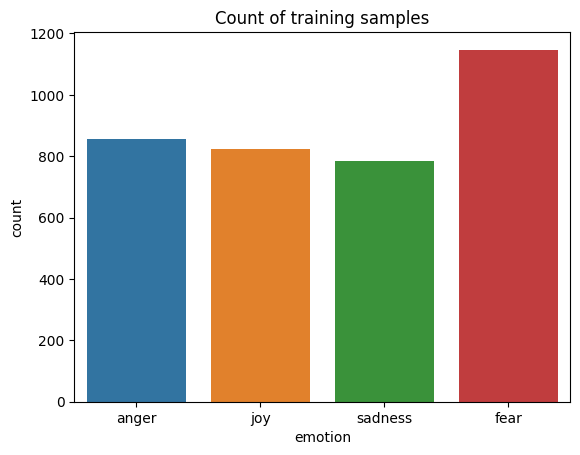

In [18]:
# Visualize training sample count

sns.countplot(train, x="emotion")
plt.title("Count of training samples")
plt.show()

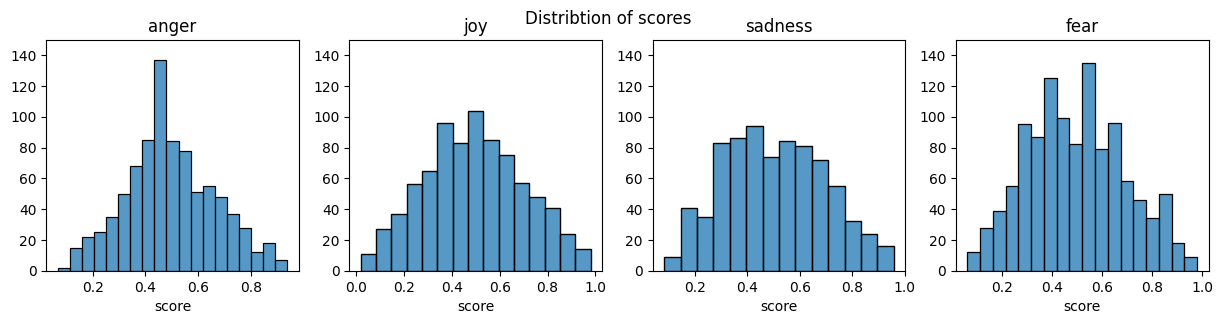

In [19]:
# Visualize distribution of scores for each emotion

plt.figure(figsize=(15,3))
for i, emo in enumerate(train["emotion"].unique().tolist()):
    plt.subplot(1, 4, i+1)
    sns.histplot(data=train[train.emotion==emo].score)
    plt.title(emo)
    plt.ylim(0, 150)
    plt.ylabel("")

plt.suptitle("Distribtion of scores")
plt.show()

# Text cleaning

In [20]:
# First step of processing --> clearing unwanted text elements

train = clean(train)
dev = clean(dev)
test = clean(test)

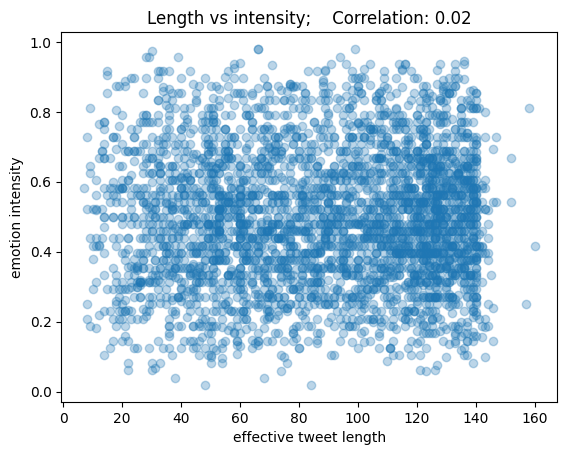

In [21]:
# Visualize correlation between effective length of tweet and emotion intensity

plt.scatter(train.length, train.score, alpha=0.3)
plt.xlabel("effective tweet length")
plt.ylabel("emotion intensity")
plt.title(f"Length vs intensity;    Correlation: {round(train.score.corr(train.length), 2)}")
plt.show()

In [22]:
# Second step of processing --> lowercase, lemmatization

train = tok_lem(train)
dev = tok_lem(dev)
test = tok_lem(test)

In [23]:
# merging clean tweets with hashtag words for corpus preparation

train["clean_tweet"] = train.clean_tweet + " " + train.hashtags
dev["clean_tweet"] = dev.clean_tweet + " " + dev.hashtags
test["clean_tweet"] = test.clean_tweet + " " + test.hashtags

# Text embedding

In [24]:
# prepare vocabulary for tf-idf from training data

training_corpus = train['clean_tweet'].tolist()
tfidf_vectorizer = TfidfVectorizer()

In [25]:
train_tfidf = tfidf_vectorizer.fit_transform(training_corpus)
feature_names = tfidf_vectorizer.get_feature_names_out()
train_tfidf = pd.DataFrame(data=train_tfidf.toarray(), columns=feature_names)

dev_tfidf = tfidf_vectorizer.transform(dev['clean_tweet'].tolist())
dev_tfidf = pd.DataFrame(data=dev_tfidf.toarray(), columns=feature_names)

test_tfidf = tfidf_vectorizer.transform(test['clean_tweet'].tolist())
test_tfidf = pd.DataFrame(data=test_tfidf.toarray(), columns=feature_names)

In [26]:
# vectorized dataframe shape --> (no. of tweets, unique words in training data)

train_tfidf

,aaron,aat,aateam,abbys,aber,aberdeen,abhijit,ability,abla,able,...,zephaniah,zero,zeth,zika,zilch,zionist,zombie,zone,zoolander,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# one hot encode "emotion" feature

train_emo = get_dummies(train[['emotion']])
dev_emo = get_dummies(dev[['emotion']])
test_emo = get_dummies(test[['emotion']])


# adding one hot encoded column for anger in test data to maintain uniform structure

test_emo['emotion_anger'] = [0]*len(test_emo)
test_emo = test_emo[list(train_emo.columns.values)]

# Data Modelling

## K nearest neighbors

In [28]:
# concatenate vectorized words and one hot encoded emotions for X

X_train = pd.concat([train_tfidf, train_emo], axis=1)
X_dev = pd.concat([dev_tfidf, dev_emo], axis=1)
X_test = pd.concat([test_tfidf, test_emo], axis=1)


y_train = train.score
y_dev = dev.score
y_test = test.score

In [29]:
# parameter grid for grid search along with custom scoring function

n_neighbors = np.arange(2, 21, 2)
estimator = KNeighborsRegressor(weights='distance', n_jobs=-1)

param_grid = {'n_neighbors': n_neighbors}

In [30]:
grid_rf = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring=make_scorer(custom_scorer), verbose=4)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=2;, score=0.385 total time=   1.7s
[CV 2/5] END .....................n_neighbors=2;, score=0.387 total time=   1.6s
[CV 3/5] END .....................n_neighbors=2;, score=0.434 total time=   2.3s
[CV 4/5] END .....................n_neighbors=2;, score=0.475 total time=   2.3s
[CV 5/5] END .....................n_neighbors=2;, score=0.416 total time=   1.7s
[CV 1/5] END .....................n_neighbors=4;, score=0.471 total time=   1.5s
[CV 2/5] END .....................n_neighbors=4;, score=0.477 total time=   1.5s
[CV 3/5] END .....................n_neighbors=4;, score=0.514 total time=   1.5s
[CV 4/5] END .....................n_neighbors=4;, score=0.544 total time=   1.4s
[CV 5/5] END .....................n_neighbors=4;, score=0.468 total time=   1.3s
[CV 1/5] END .....................n_neighbors=6;, score=0.520 total time=   1.3s
[CV 2/5] END .....................n_neighbors=6;

GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_jobs=-1, weights='distance'),
             param_grid={'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
             scoring=make_scorer(custom_scorer), verbose=4)

In [31]:
knn_model = grid_rf.best_estimator_
grid_rf.best_params_

{'n_neighbors': 12}

DEVELOPMENT


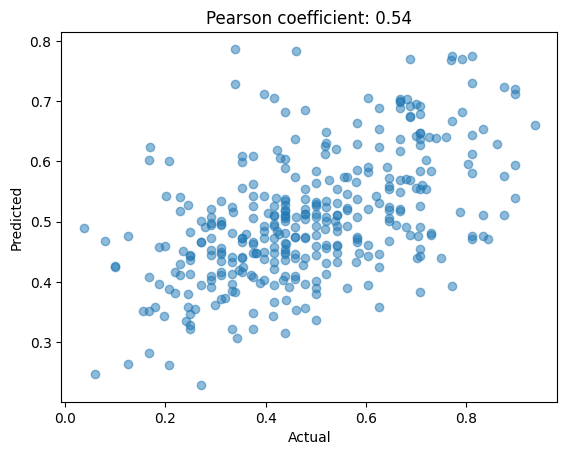

Emotion: anger,     Pearson coefficient: 0.518678258655791
Emotion: fear,     Pearson coefficient: 0.6779722967469746
Emotion: sadness,     Pearson coefficient: 0.463789282446832
Emotion: joy,     Pearson coefficient: 0.4859178138066103


In [32]:
y_dev_pred = scatter_output(knn_model, X_dev, y_dev, "development")
emo_int_pred(dev, y_dev_pred)

TEST


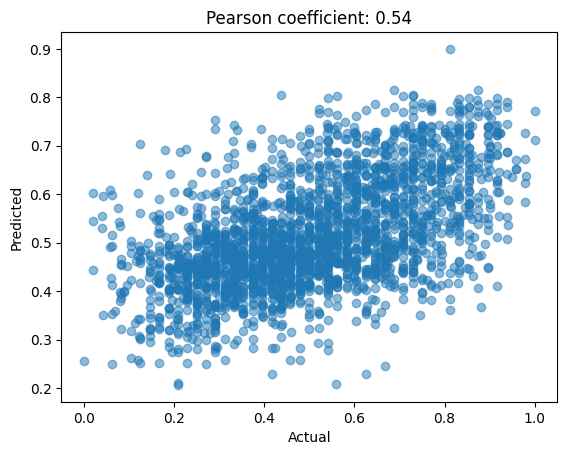

Emotion: sadness,     Pearson coefficient: 0.66108604171253
Emotion: fear,     Pearson coefficient: 0.5406635382200784
Emotion: joy,     Pearson coefficient: 0.4423631473606119


In [33]:
y_test_pred = scatter_output(knn_model, X_test, y_test, "test")
emo_int_pred(test, y_test_pred)

## Multi layer perceptron

In [34]:
# Build the MLP model. Seeded for reproducing initial state

tf.random.set_seed(9)
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=(X_train.to_numpy().shape[1],)))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))


# Compile the model with lr scheduler to avoid overfitting

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-3,
    decay_steps=1000,
    decay_rate=0.8)

opt = keras.optimizers.Nadam(learning_rate=lr_schedule)
nn_model.compile(optimizer=opt, loss=my_loss_fn)

nn_model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=10, batch_size=64, validation_data=(X_dev.to_numpy(), y_dev.to_numpy()))


Epoch 1/10
57/57 [==============================] - 4s 23ms/step - loss: 0.6342 - val_loss: 0.5131
Epoch 2/10
57/57 [==============================] - 1s 18ms/step - loss: 0.1843 - val_loss: 0.4903
Epoch 3/10
57/57 [==============================] - 1s 17ms/step - loss: 0.0843 - val_loss: 0.4901
Epoch 4/10
57/57 [==============================] - 1s 20ms/step - loss: 0.0547 - val_loss: 0.5019
Epoch 5/10
57/57 [==============================] - 1s 18ms/step - loss: 0.0432 - val_loss: 0.4989
Epoch 6/10
57/57 [==============================] - 1s 20ms/step - loss: 0.0372 - val_loss: 0.4978
Epoch 7/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0323 - val_loss: 0.5083
Epoch 8/10
57/57 [==============================] - 1s 17ms/step - loss: 0.0283 - val_loss: 0.5021
Epoch 9/10
57/57 [==============================] - 1s 17ms/step - loss: 0.0244 - val_loss: 0.5057
Epoch 10/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0207 - val_loss: 0.5131


11/11 [==============================] - 0s 5ms/step
DEVELOPMENT


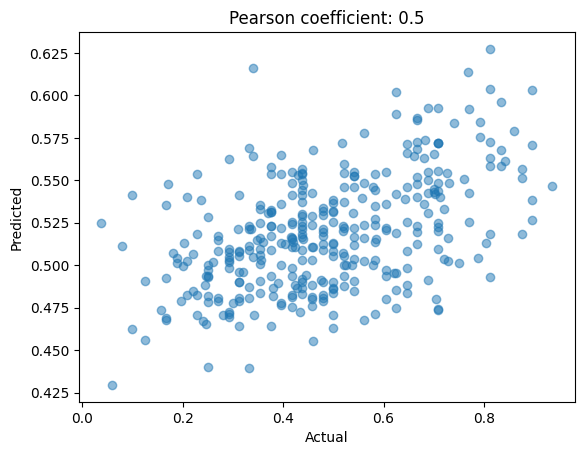

Emotion: anger,     Pearson coefficient: 0.47248154806872333
Emotion: fear,     Pearson coefficient: 0.6642474556839981
Emotion: sadness,     Pearson coefficient: 0.43586831830715705
Emotion: joy,     Pearson coefficient: 0.3797853961532917


In [35]:
y_dev_pred = scatter_output(nn_model, X_dev.to_numpy(), y_dev, "development")
emo_int_pred(dev, y_dev_pred)

75/75 [==============================] - 0s 4ms/step
TEST


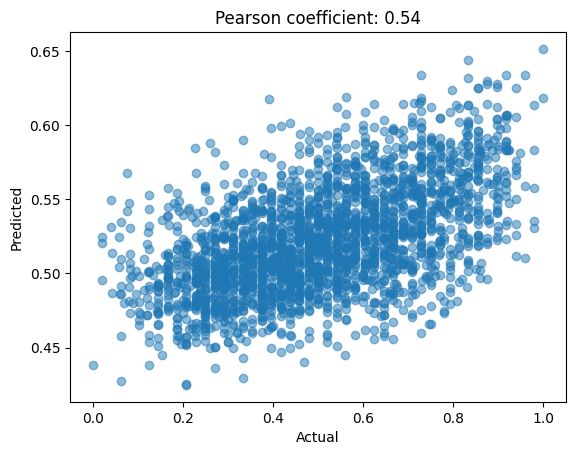

Emotion: sadness,     Pearson coefficient: 0.6473288401481962
Emotion: fear,     Pearson coefficient: 0.5664609006557588
Emotion: joy,     Pearson coefficient: 0.4091792815691905


In [36]:
y_test_pred = scatter_output(nn_model, X_test.to_numpy(), y_test, "test")
emo_int_pred(test, y_test_pred)